<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Multiple Linear Regression


Estimated time needed: **15** minutes
    

## Objectives

After completing this lab you will be able to:

* Use scikit-learn to implement Multiple Linear Regression
* Create a model, train it, test it and use the model


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#understanding-data">Understanding the Data</a></li>
        <li><a href="#reading_data">Reading the Data in</a></li>
        <li><a href="#multiple_regression_model">Multiple Regression Model</a></li>
        <li><a href="#prediction">Prediction</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


### Importing Needed packages


In [1]:
import piplite
await piplite.install(['pandas'])
await piplite.install(['matplotlib'])
await piplite.install(['numpy'])
await piplite.install(['scikit-learn'])


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline

### Downloading Data
we will use the link, we will use !wget to download it from IBM Object Storage.


In [3]:
path='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv'

In [4]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())

__Did you know?__ When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)



<h2 id="understanding_data">Understanding the Data</h2>

### `FuelConsumption.csv`:
We have downloaded a fuel consumption dataset, **`FuelConsumption.csv`**, which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. [Dataset source](http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64)

- **MODELYEAR** e.g. 2014
- **MAKE** e.g. Acura
- **MODEL** e.g. ILX
- **VEHICLE CLASS** e.g. SUV
- **ENGINE SIZE** e.g. 4.7
- **CYLINDERS** e.g 6
- **TRANSMISSION** e.g. A6
- **FUELTYPE** e.g. z
- **FUEL CONSUMPTION in CITY(L/100 km)** e.g. 9.9
- **FUEL CONSUMPTION in HWY (L/100 km)** e.g. 8.9
- **FUEL CONSUMPTION COMB (L/100 km)** e.g. 9.2
- **CO2 EMISSIONS (g/km)** e.g. 182   --> low --> 0


<h2 id="reading_data">Reading the data in</h2>


In [5]:
await download(path, "FuelConsumption.csv")
path="FuelConsumption.csv"

In [6]:
df = pd.read_csv(path)

# take a look at the dataset
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


Let's select some features that we want to use for regression.


In [7]:
cdf = df[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB','CO2EMISSIONS']]
cdf.head(9)

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,CO2EMISSIONS
0,2.0,4,9.9,6.7,8.5,196
1,2.4,4,11.2,7.7,9.6,221
2,1.5,4,6.0,5.8,5.9,136
3,3.5,6,12.7,9.1,11.1,255
4,3.5,6,12.1,8.7,10.6,244
5,3.5,6,11.9,7.7,10.0,230
6,3.5,6,11.8,8.1,10.1,232
7,3.7,6,12.8,9.0,11.1,255
8,3.7,6,13.4,9.5,11.6,267


Let's plot Emission values with respect to Engine size:


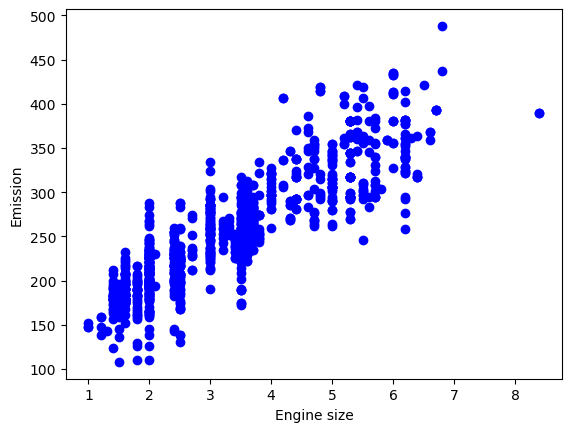

In [8]:
plt.scatter(cdf.ENGINESIZE, cdf.CO2EMISSIONS,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

#### Creating train and test dataset
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. 
This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the model. Therefore, it gives us a better understanding of how well our model generalizes on new data.

We know the outcome of each data point in the testing dataset, making it great to test with! Since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Let's split our dataset into train and test sets. Around 80% of the entire dataset will be used for training and 20% for testing. We create a mask to select random rows using the  __np.random.rand()__ function: 


In [9]:
msk = np.random.rand(len(df)) < 0.8
train = cdf[msk]
test = cdf[~msk]

#### Train data distribution


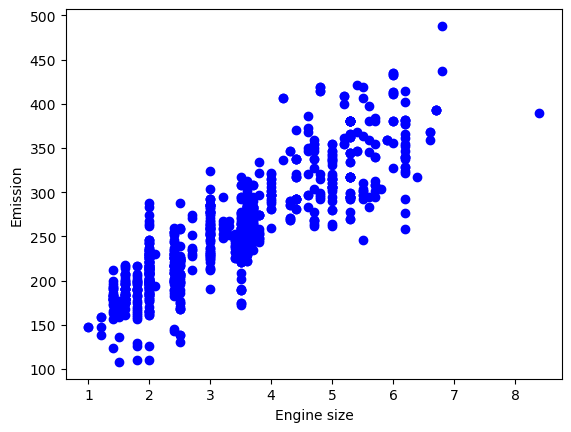

In [10]:
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

<h2 id="multiple_regression_model">Multiple Regression Model</h2>


In reality, there are multiple variables that impact the co2emission. When more than one independent variable is present, the process is called multiple linear regression. An example of multiple linear regression is predicting co2emission using the features FUELCONSUMPTION_COMB, EngineSize and Cylinders of cars. The good thing here is that multiple linear regression model is the extension of the simple linear regression model.


In [11]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']])
y = np.asanyarray(train[['CO2EMISSIONS']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[11.26063854  7.23884258  9.81033708]]


As mentioned before, __Coefficient__ and __Intercept__  are the parameters of the fitted line. 
Given that it is a multiple linear regression model with 3 parameters and that the parameters are the intercept and coefficients of the hyperplane, sklearn can estimate them from our data. Scikit-learn uses plain Ordinary Least Squares method to solve this problem.

#### Ordinary Least Squares (OLS)
OLS is a method for estimating the unknown parameters in a linear regression model. OLS chooses the parameters of a linear function of a set of explanatory variables by minimizing the sum of the squares of the differences between the target dependent variable and those predicted by the linear function. In other words, it tries to minimizes the sum of squared errors (SSE) or mean squared error (MSE) between the target variable (y) and our predicted output ($\hat{y}$) over all samples in the dataset.

OLS can find the best parameters using of the following methods:
* Solving the model parameters analytically using closed-form equations
* Using an optimization algorithm (Gradient Descent, Stochastic Gradient Descent, Newton’s Method, etc.)


<h2 id="prediction">Prediction</h2>


In [12]:
y_hat= regr.predict(test[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']])
x = np.asanyarray(test[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']])
y = np.asanyarray(test[['CO2EMISSIONS']])
print("Mean Squared error(MSE): %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Mean Squared error(MSE): 475.27
Variance score: 0.87


__Explained variance regression score:__  
Let $\hat{y}$ be the estimated target output, y the corresponding (correct) target output, and Var be the Variance (the square of the standard deviation). Then the explained variance is estimated as follows:

$\texttt{explainedVariance}(y, \hat{y}) = 1 - \frac{Var\{ y - \hat{y}\}}{Var\{y\}}$  
The best possible score is 1.0, the lower values are worse.


<h2 id="practice">Practice</h2>
Try to use a multiple linear regression with the same dataset, but this time use FUELCONSUMPTION_CITY and FUELCONSUMPTION_HWY instead of FUELCONSUMPTION_COMB. Does it result in better accuracy?


In [13]:
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY']])
y = np.asanyarray(train[['CO2EMISSIONS']])
regr.fit (x, y)
print ('Coefficients: ', regr.coef_)
y_= regr.predict(test[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY']])
x = np.asanyarray(test[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY']])
y = np.asanyarray(test[['CO2EMISSIONS']])
print("Residual sum of squares: %.2f"% np.mean((y_ - y) ** 2))
print('Variance score: %.2f' % regr.score(x, y))

Coefficients:  [[11.37283662  6.98182608  5.99950015  3.6010626 ]]


/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Residual sum of squares: 473.13
Variance score: 0.87


<details><summary>Click here for the solution</summary>

```python
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY']])
y = np.asanyarray(train[['CO2EMISSIONS']])
regr.fit (x, y)
print ('Coefficients: ', regr.coef_)
y_= regr.predict(test[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY']])
x = np.asanyarray(test[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY']])
y = np.asanyarray(test[['CO2EMISSIONS']])
print("Residual sum of squares: %.2f"% np.mean((y_ - y) ** 2))
print('Variance score: %.2f' % regr.score(x, y))

```

</details>


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="https://www.ibm.com/analytics/spss-statistics-software?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork1047-2023-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://www.ibm.com/cloud/watson-studio?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork1047-2023-01-01">Watson Studio</a>



### Thank you for completing this lab!


## Author

Saeed Aghabozorgi


### Other Contributors

<a href="https://www.linkedin.com/in/joseph-s-50398b136/" target="_blank">Joseph Santarcangelo</a>




## Change Log


|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-11-03  | 2.1  | Lakshmi  | Made changes in URL |
| 2020-08-27  | 2.0  | Lavanya  |  Moved lab to course repo in GitLab |
|   |   |   |   |
|   |   |   |   |


## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
